# EXPLORATION 11 어제 오른 내 주식, 과연 내일은?

# SAMSUNG

**Import**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import warnings
warnings.filterwarnings('ignore')

print('🍨')

🍨


**시계열 데이터 준비**

In [2]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/207940.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
samsung_ts = df['Close']
print(type(samsung_ts))
samsung_ts.head()

<class 'pandas.core.series.Series'>


Date
2021-02-15    800000.0
2021-02-16    796000.0
2021-02-17    786000.0
2021-02-18    783000.0
2021-02-19    793000.0
Name: Close, dtype: float64

**각종 전처리 수행**

In [3]:
# 결측치 처리
samsung_ts=samsung_ts.interpolate(method='time')
samsung_ts[samsung_ts.isna()]

Series([], Name: Close, dtype: float64)

In [4]:
# 로그 변환 시도
samsung_ts_log = np.log(samsung_ts)

**시계열 안정성 분석**

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [6]:
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

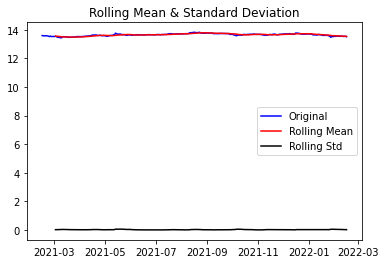

Results of Dickey-Fuller Test:
Test Statistic                  -1.820985
p-value                          0.370094
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


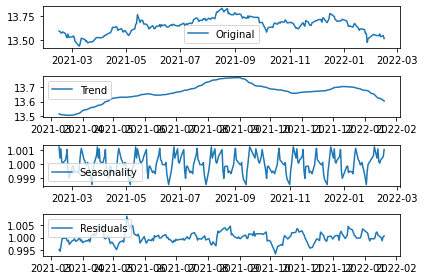

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(samsung_ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(samsung_ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(samsung_ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(samsung_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [8]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.794285e+00
p-value                        4.792077e-07
#Lags Used                     4.000000e+00
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Value (5%)           -2.875207e+00
Critical Value (10%)          -2.574054e+00
dtype: float64


**학습, 테스트 데이터셋 생성**

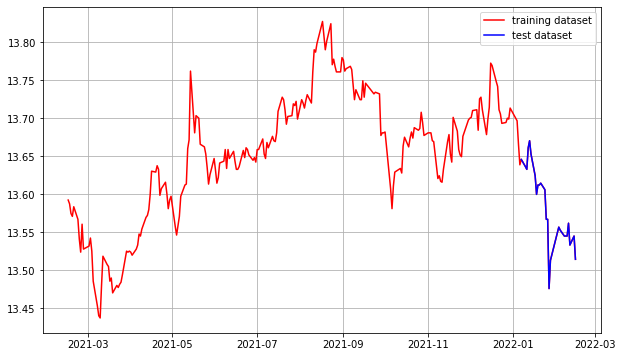

In [9]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = samsung_ts_log[:int(len(samsung_ts_log)*0.9)], samsung_ts_log[int(len(samsung_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(samsung_ts_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

**적정 ARIMA 모수 찾기**

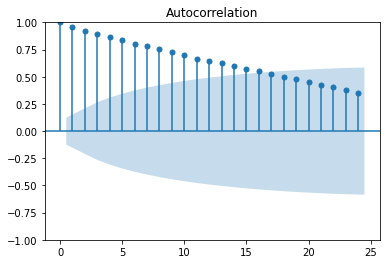

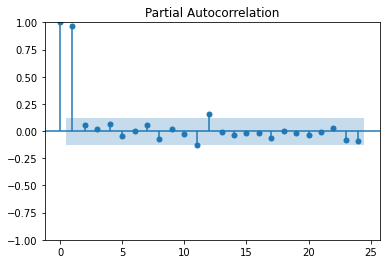

In [10]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(samsung_ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(samsung_ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.642678e+01
p-value                        2.500307e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


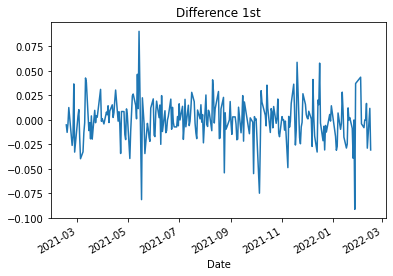

In [11]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = samsung_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.308204e+00
p-value                        1.284807e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


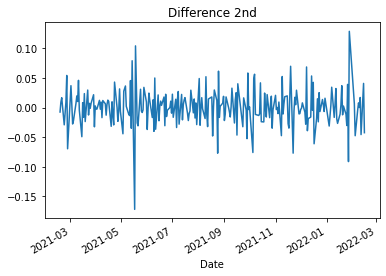

In [12]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

**ARIMA 모델 훈련과 테스트**

In [13]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 547.359
Date:                Wed, 16 Feb 2022   AIC                          -1084.717
Time:                        13:00:03   BIC                          -1067.681
Sample:                             0   HQIC                         -1077.840
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.6457      0.039    351.461      0.000      13.570      13.722
ar.L1          0.1969      1.748      0.113      0.910      -3.230       3.624
ar.L2          0.7414      1.678      0.442      0.6

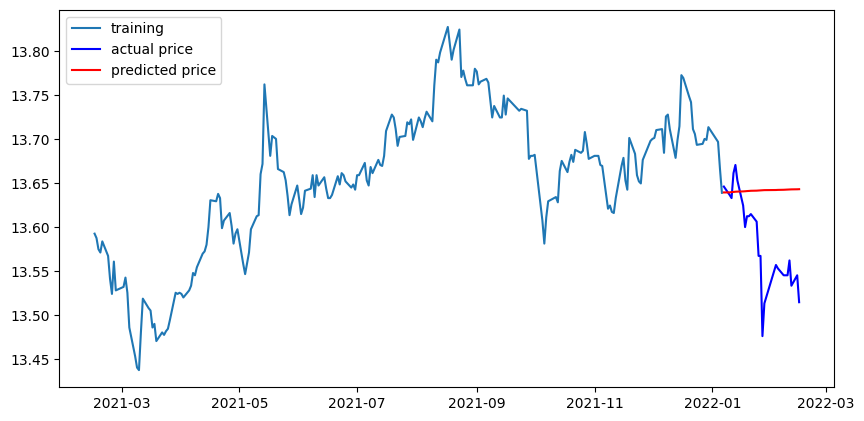

In [14]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3820018766.365095
MAE:  50869.92772187918
RMSE:  61806.300377591724
MAPE: 6.64%


# Intel

**시계열 데이터 준비**

In [16]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/INTC.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
intel_ts = df['Close']
print(type(intel_ts))
intel_ts.head()

<class 'pandas.core.series.Series'>


Date
2021-02-16    62.470001
2021-02-17    61.849998
2021-02-18    61.610001
2021-02-19    63.009998
2021-02-22    60.709999
Name: Close, dtype: float64

**각종 전처리 수행**

In [17]:
# 결측치 처리
intel_ts=intel_ts.interpolate(method='time')
intel_ts[intel_ts.isna()]

Series([], Name: Close, dtype: float64)

In [18]:
# 로그 변환 시도
intel_ts_log = np.log(intel_ts)

**시계열 안정성 분석**

In [19]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [20]:
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

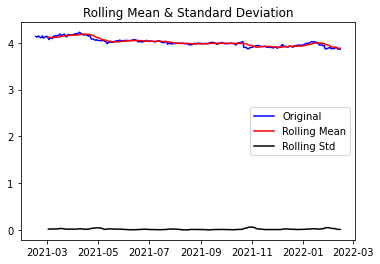

Results of Dickey-Fuller Test:
Test Statistic                  -1.636408
p-value                          0.464138
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


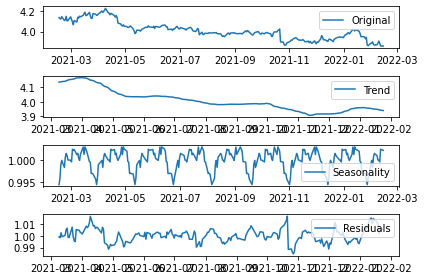

In [21]:
# 정성적 그래프 분석
plot_rolling_statistics(intel_ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(intel_ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(intel_ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(intel_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [22]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.298404
p-value                          0.000006
#Lags Used                       2.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


**학습, 테스트 데이터셋 생성**

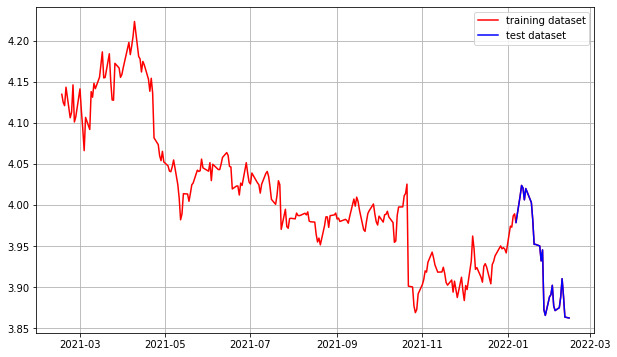

In [23]:
train_data, test_data = intel_ts_log[:int(len(intel_ts_log)*0.9)], intel_ts_log[int(len(intel_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(intel_ts_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

**적정 ARIMA 모수 찾기**

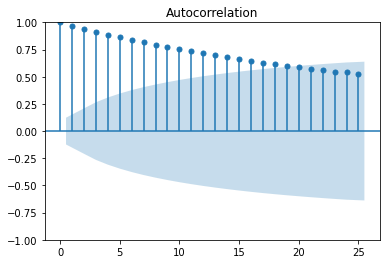

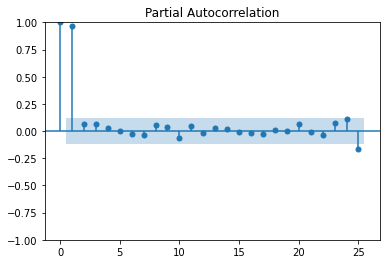

In [24]:
plot_acf(intel_ts_log)   
plot_pacf(intel_ts_log)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.741223e+01
p-value                        4.878509e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


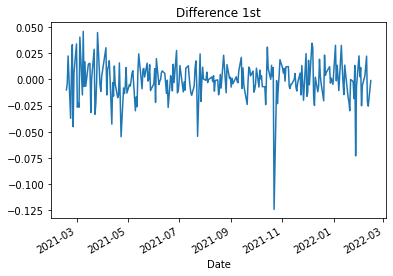

In [25]:
diff_1 = intel_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.798007e+00
p-value                        7.625492e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


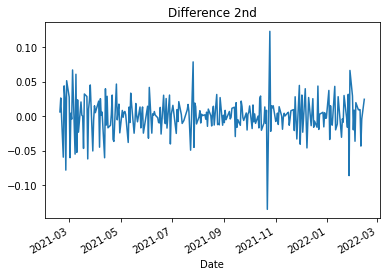

In [26]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

**ARIMA 모델 훈련과 테스트**

In [27]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 592.788
Date:                Wed, 16 Feb 2022   AIC                          -1175.575
Time:                        13:00:05   BIC                          -1158.451
Sample:                             0   HQIC                         -1168.665
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0310      0.045     90.027      0.000       3.943       4.119
ar.L1          1.1841      0.536      2.209      0.027       0.134       2.235
ar.L2         -0.1992      0.524     -0.380      0.7

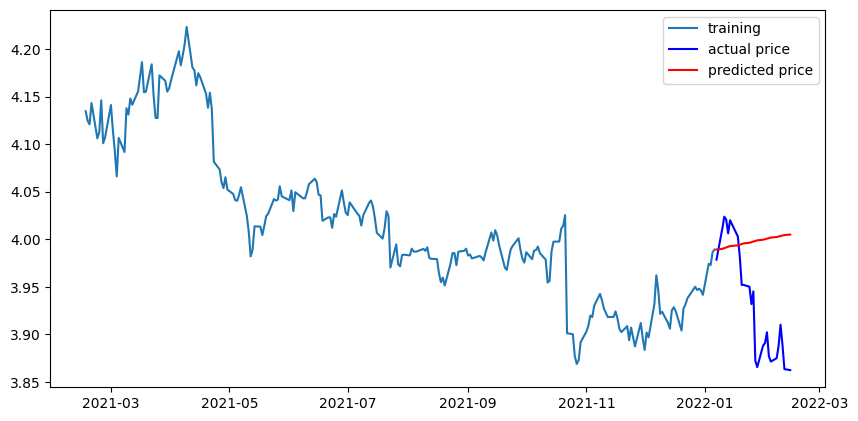

In [28]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  21.3357859715296
MAE:  3.9452397413885927
RMSE:  4.619067651759346
MAPE: 8.00%


# EVIDIA

**시계열 데이터 준비**

In [30]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/NVDA.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
nvidia_ts = df['Close']
print(type(nvidia_ts))
nvidia_ts.head()

<class 'pandas.core.series.Series'>


Date
2021-02-16    153.302505
2021-02-17    149.059998
2021-02-18    148.289993
2021-02-19    149.264999
2021-02-22    143.557495
Name: Close, dtype: float64

**각종 전처리 수행**

In [31]:
# 결측치 처리
nvidia_ts=nvidia_ts.interpolate(method='time')
nvidia_ts[nvidia_ts.isna()]

Series([], Name: Close, dtype: float64)

In [32]:
# 로그 변환 시도
nvidia_ts_log = np.log(nvidia_ts)

**시계열 안정성 분석**

In [33]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [34]:
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

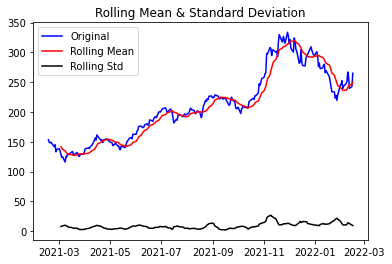

Results of Dickey-Fuller Test:
Test Statistic                  -0.857815
p-value                          0.801547
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


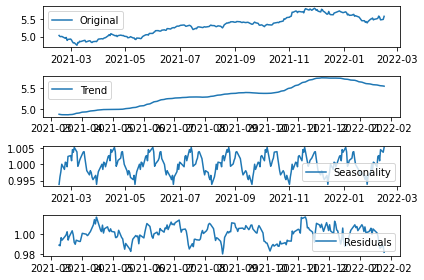

In [35]:
# 정성적 그래프 분석
plot_rolling_statistics(nvidia_ts, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(nvidia_ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(nvidia_ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(nvidia_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [36]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.516726
p-value                          0.000183
#Lags Used                       6.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


**학습, 테스트 데이터셋 생성**

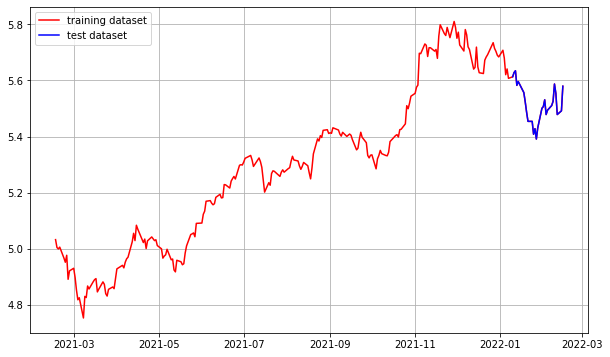

In [37]:
train_data, test_data = nvidia_ts_log[:int(len(nvidia_ts_log)*0.9)], nvidia_ts_log[int(len(nvidia_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(nvidia_ts_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

**적정 ARIMA 모수 찾기**

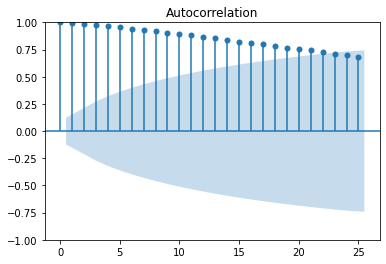

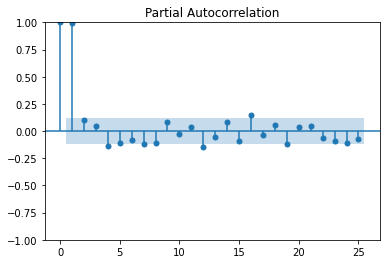

In [38]:
plot_acf(nvidia_ts_log)   
plot_pacf(nvidia_ts_log)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -5.011317
p-value                          0.000021
#Lags Used                       5.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


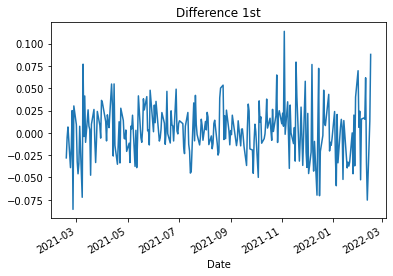

In [39]:
diff_1 = nvidia_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.405978e+01
p-value                        3.071207e-26
#Lags Used                     4.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


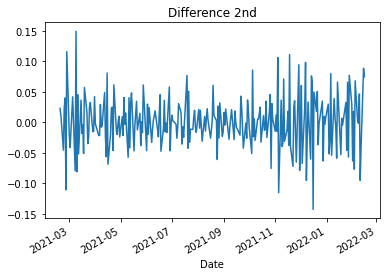

In [40]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

**ARIMA 모델 훈련과 테스트**

In [41]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 484.848
Date:                Wed, 16 Feb 2022   AIC                           -959.696
Time:                        13:00:07   BIC                           -942.549
Sample:                             0   HQIC                          -952.778
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3088      0.312     17.009      0.000       4.697       5.921
ar.L1          1.1570      1.213      0.954      0.340      -1.221       3.535
ar.L2         -0.1599      1.209     -0.132      0.8

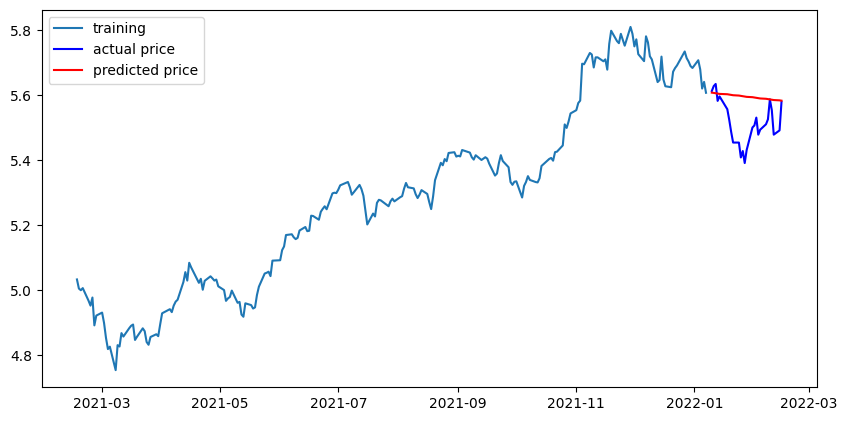

In [42]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  656.0311519491077
MAE:  21.103049596689637
RMSE:  25.61310508214706
MAPE: 8.88%


# [E-11] 회고

이번 익스는 노드가 힘들었지 과제를 수행하는데 있어서 크나큰 시련은 없었던 것 같아요😁

Yahoo Finance에서 주식 데이터(samsung, intel, ndivia)를 가지고 오고, 노드를 따라서 과제를 진행했고,
중간 중간 Time Series와 log 변수명을 바꿔주고 결과를 확인했습니다.

잘 진행하고 있다가 몇 번 오류가 난 적이 있는데,
한 번은 확장자명을 제대로 작성하지 않거나, '.(온점, 피리어드)'을 습관적으로 작성해서 일어난 해프닝이었고,

또 다른 한 번은 제일 처음 Impor 모듈을 가져오는 과정에서 생겼습니다.

ARIMA 모델 훈련과 테스트를 하면서 사용한 from statsmodels.tsa.arima.model import ARIMA과 from sklearn.metrics import mean_squared_error, mean_absolute_error
import math를 한 번에 같이 처리할 생각으로 모듈을 가지고 왔는데요😂

무슨 이유인지는 아직 못 찾았는데, 오류가 나더라구요 그래서 각각의 주식 분석마다 다시 from statsmodels.tsa.arima.model import ARIMA과 from sklearn.metrics import mean_squared_error, mean_absolute_error를 적어주었습니다.

이번 익스11번은 제가 수행했던 과제 중에서 제일 즐거웠던 것 같아요.🥰🥰
(꼭 이런말을 하면 다음에 변수가 생기던데😅😅 그래도 즐거웠습니다.)

(이번 노드 BGM🎵 High Hopes - Panic! At the Disco)